In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from src.IterativeFitting import IterativeFitting as IF
from src.CorrFuncs import covariance_matrix, trend_est

In [2]:
def create_covar_matrix(study_df,std_rise,Lx,dose_index=1):
    Nx_s = study_df["subjects"].to_numpy().astype(np.float64)
    Lx_s = study_df[Lx].to_numpy().astype(np.float64)[dose_index:]
    M1x_s = np.sum(study_df["cases"].to_numpy().astype(np.float64))
    A0_s = M1x_s*Nx_s[1:]/(Nx_s.sum())

    it_fit_ex = IF(Lx_s,A0_s,Nx_s,M1x_s)
    A_s, B_s, a0_s, b0_s = it_fit_ex.convexProgram()

    C = covariance_matrix(A_s,B_s,a0_s,b0_s,std_rise**2)
    inv_C = np.linalg.inv(C)

    return C, inv_C

In [3]:
# Reading in data
study_df = pd.read_excel("SBPvPAD_data.xlsx")

# Taking care of non-log values in dataframe
study_df.iloc[0,5:8] = np.log(study_df.iloc[0,5:8].to_numpy().astype(np.float64))
study_df.iloc[5,5:8] = np.log(study_df.iloc[5,5:8].to_numpy().astype(np.float64))

# Creating Itoga-specific dataframe
study_df_i = study_df.loc[study_df["Author"] == "Itoga"]
# study_df_i_bref = study_df_i.iloc[[0]]
# study_df_i_aref = study_df_i.iloc[1:]
# study_df_i = pd.concat([study_df_i_aref,study_df_i_bref],ignore_index=True)
study_df_i = study_df_i.iloc[1:,:]

# Create exposure levels relative to reference exposure
x_i = study_df_i["dose"].to_numpy()[1:] - study_df_i["dose"].to_numpy()[0]

# Get log-odds and corresponding variance estimates
L_i = study_df_i["logOR"].to_numpy()[1:]
v_i = study_df_i["std_error"].to_numpy()[1:]

In [5]:
study_df_i

,Author,dose,cases,controls,subjects,logOR,low,high,std_error
5,Itoga,129.8,249.666667,2738.333333,2988.0,0.000,0.0000,0.000,0.000000
6,Itoga,134.6,249.666667,6048.333333,6298.0,-0.062,-0.1500,-0.023,0.032071
7,Itoga,139.0,249.666667,9341.333333,9591.0,0.077,0.0004,0.150,0.037778
8,Itoga,143.7,249.666667,8543.333333,8793.0,0.110,0.0220,0.210,0.047475
9,Itoga,149.5,249.666667,4401.333333,4651.0,0.190,0.1100,0.280,0.042929


Regular regression estimates

In [6]:
# Generating covariance matrix and inverse
Cr, inv_Cr = create_covar_matrix(study_df_i, v_i, "logOR")

In [19]:
# Itoga corrected estimates
vb_star = 1/(np.dot(x_i,np.dot(inv_Cr,x_i)))
b_star = vb_star*(np.dot(x_i,np.dot(inv_Cr,L_i)))
b_star

0.013229983200685035

In [20]:
(x_i.T@inv_Cr@L_i)/(x_i.T@inv_Cr@x_i)

0.01322998320068504

In [68]:
from scipy.linalg import sqrtm
root_P = sqrtm(inv_Cr)
root_P = root_P /np.trace(root_P) * len(root_P)

In [86]:
root_P

array([[ 1.19108636, -0.22702749, -0.20630437, -0.15105753],
       [-0.22702749,  1.10865375, -0.27313058, -0.19972673],
       [-0.20630437, -0.27313058,  0.84464652, -0.18705751],
       [-0.15105753, -0.19972673, -0.18705751,  0.85561337]])

/var/folders/6x/8csly98d7wb6flnxzkv2shcc0000gp/T/ipykernel_60308/2612231799.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol,_,_,_ = np.linalg.lstsq(X_transformed[:,:1],root_P@L_i)


Text(0.5, 1.0, 'Before Transformation')

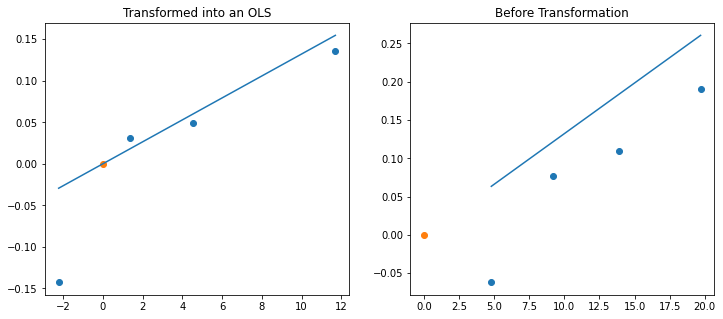

In [75]:
X_transformed = (np.vstack([root_P@x_i,root_P@np.ones(len(x_i))])).T

sol,_,_,_ = np.linalg.lstsq(X_transformed[:,:1],root_P@L_i)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(root_P@x_i,root_P@L_i)
plt.scatter(0,0)
Px = root_P@x_i
Pl = root_P@L_i
plt.plot(Px,Px*sol[0])
plt.title("Transformed into an OLS")

plt.subplot(1,2,2)
plt.scatter(x_i,L_i)
plt.plot(x_i,x_i * sol[0])
plt.scatter(0,0)
plt.title("Before Transformation")

In [89]:
X_transformed

array([[-2.2149024 ,  0.60669697],
       [ 1.37875076,  0.40876894],
       [ 4.55249131,  0.17815406],
       [11.69292195,  0.3177716 ]])

/var/folders/6x/8csly98d7wb6flnxzkv2shcc0000gp/T/ipykernel_60308/1655349650.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol,_,_,_ = np.linalg.lstsq(X_transformed,root_P@L_i)


Text(0.5, 1.0, 'Before Transformation')

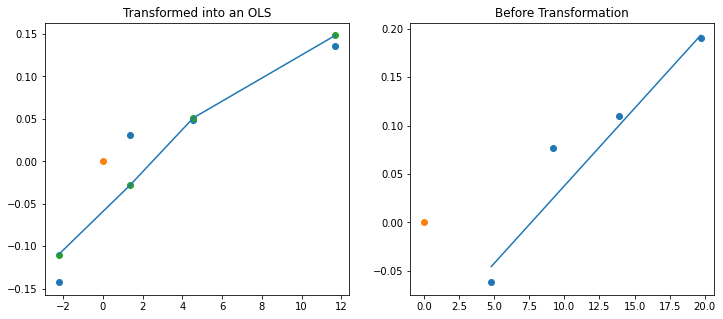

In [100]:
X_transformed = (np.vstack([root_P@x_i,root_P@np.ones(len(x_i))])).T

sol,_,_,_ = np.linalg.lstsq(X_transformed,root_P@L_i)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(root_P@x_i,root_P@L_i)
plt.scatter(0,0)
Px = root_P@x_i
Pl = root_P@L_i
plt.scatter(Px,X_transformed@sol)
plt.plot(Px,X_transformed@sol)

plt.title("Transformed into an OLS")

plt.subplot(1,2,2)
plt.scatter(x_i,L_i)
plt.plot(x_i,x_i * sol[0] + sol[1])
plt.scatter(0,0)
plt.title("Before Transformation")

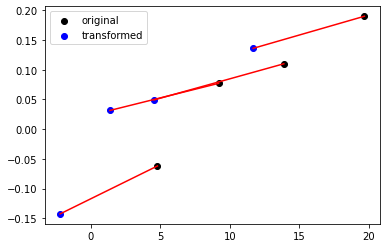

In [80]:
Px = root_P@x_i
PL = root_P@L_i

for i in range(len(x_i)):
    plt.plot([x_i[i],Px[i]],[L_i[i],PL[i]],c='red')

plt.scatter(x_i,L_i,c='black',label = 'original')
plt.scatter(Px,PL,c='blue',label = 'transformed')
plt.legend()

Text(0.5, 1.0, 'Before Transformation')

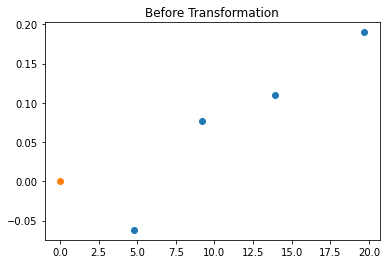

In [33]:
plt.scatter(x_i,L_i)
plt.scatter(0,0)
plt.title("Before Transformation")

In [18]:
# Itoga unadjusted estimates
vb = 1/(np.dot(x_i,np.dot(np.linalg.inv(np.diag(v_i)**2),x_i)))
b = vb*(np.dot(x_i,np.dot(np.linalg.inv(np.diag(v_i)**2),L_i)))
b

0.0077151064467757356

array([-0.062,  0.077,  0.11 ,  0.19 ])

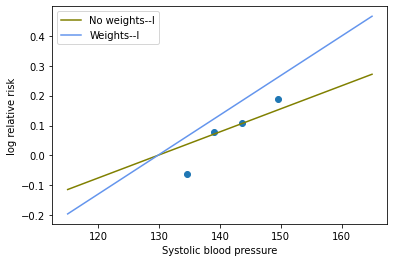

In [17]:
def slope_fn(beta,x):
    return beta*(x-129.8)

x = np.linspace(115,165)

# plt.plot(x,slope_fn(beta_s,x),label="No weights--S",c="olive")
# # plt.fill_between(x,slope_fn(low_beta_s,x),slope_fn(high_beta_s,x),alpha=0.3,color="olive")
# plt.plot(x,slope_fn(beta_s_GL,x),label="Weights--S",c="cornflowerblue")
# plt.fill_between(x,slope_fn(low_beta_s_GL,x),slope_fn(high_beta_s_GL,x),alpha=0.3,color="cornflowerblue")
plt.plot(x,slope_fn(b,x),label="No weights--I",c="olive")
plt.plot(x,slope_fn(b_star,x),label="Weights--I",c="cornflowerblue")
#plt.scatter(study_df_i["dose"],study_df_i["logOR"])

plt.scatter(x_i+129.8,L_i)
plt.ylabel("log relative risk")
plt.xlabel("Systolic blood pressure")
plt.legend()

Quadratic regression

In [11]:
x_2 = x_i**2

In [12]:
X = np.hstack((np.array([x_2]).T,np.array([x_i]).T))

In [13]:
V = np.diag(v_i**2)

In [14]:
theta_vanilla = np.linalg.inv(X.T@np.linalg.inv(V)@X)@X.T@np.linalg.inv(V)@L_i

In [15]:
theta_vanilla

array([ 0.00072458, -0.00377263])

In [16]:
theta_adjusted = np.linalg.inv(X.T@inv_Cr@X)@X.T@inv_Cr@L_i

In [17]:
theta_adjusted

array([0.00044368, 0.0033715 ])

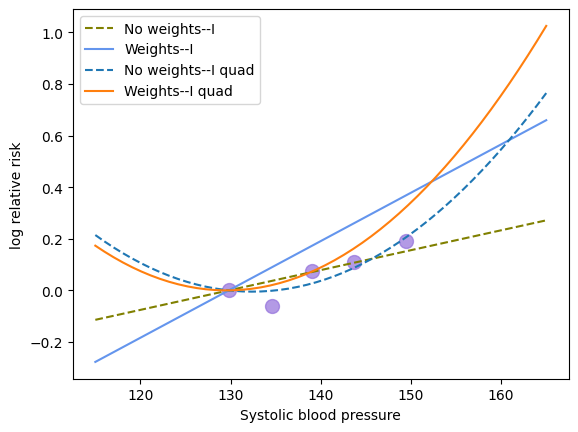

In [42]:
def quad_fn(theta,x):
    return theta[0]*(x-129.8)**2 + theta[1]*(x-129.8)

plt.plot(x,slope_fn(b,x),label="No weights--I",c="olive",linestyle="dashed")
plt.plot(x,slope_fn(b_star,x),label="Weights--I",c="cornflowerblue")
plt.plot(x,quad_fn(theta_vanilla,x),label="No weights--I quad", linestyle="dashed")
plt.plot(x,quad_fn(theta_adjusted,x),label="Weights--I quad")
plt.scatter(study_df_i["dose"],study_df_i["logOR"],s=100,c="mediumpurple",alpha=0.7)
plt.ylabel("log relative risk")
plt.xlabel("Systolic blood pressure")
plt.legend()

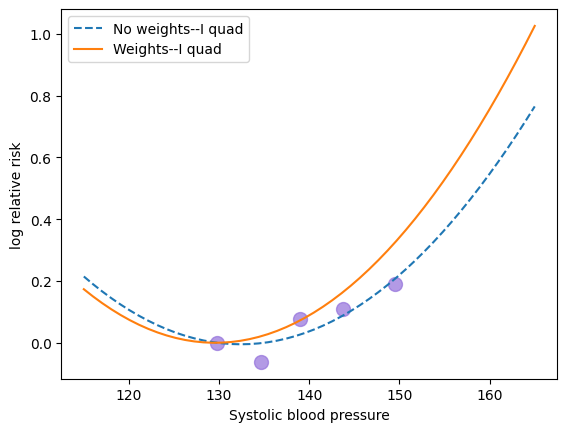

In [43]:
# plt.plot(x,slope_fn(b,x),label="No weights--I",c="olive",linestyle="dashed")
# plt.plot(x,slope_fn(b_star,x),label="Weights--I",c="cornflowerblue")
plt.plot(x,quad_fn(theta_vanilla,x),label="No weights--I quad", linestyle="dashed")
plt.plot(x,quad_fn(theta_adjusted,x),label="Weights--I quad")
plt.scatter(study_df_i["dose"],study_df_i["logOR"],s=100,c="mediumpurple",alpha=0.7)
plt.ylabel("log relative risk")
plt.xlabel("Systolic blood pressure")
plt.legend()